# [Phystech@DataScience](https://thetahat.ru/)
## Метод k-ближайших соседей


In [ ]:
!pip install scikit-learn

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# обратите внимание, что Scikit-Learn импортируется как sklearn
from sklearn import datasets
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# фиксируем seed для воспроизводимости результатов
random_state = 42

## Распознавание рукописных цифр с помощью kNN


### 1. Датасет mnist

Пакет `sklearn.datasets` позволяет загружать наборы данных из репозитория.

Загрузим датасет **MNIST**.

Датасет **MNIST** (Modified National Institute of Standards and Technology) — это один из самых известных и широко используемых наборов данных для обучения и тестирования алгоритмов машинного обучения, особенно в области распознавания изображений. Он состоит из рукописных цифр и часто используется для задач классификации.



In [18]:
mnist = fetch_openml("mnist_784")

Каждый объект в наборе данных представлен в виде **черно-белого** (в градациях серого) изображения размером **28x28 пикселей**.

Каждый пиксель имеет значение в диапазоне от **0 до 255**, где:

- **0** соответствует полностью черному цвету (это фон),
- **255** — полностью белому (это сама цифра).

Таким образом, чем выше значение пикселя, тем светлее он выглядит, приближаясь к белому цвету.

Каждое изображение связано с **меткой класса**, представляющей собой одну из цифр от **0 до 9**. Эта метка указывает, какую именно цифру содержит данное изображение.

Данные изображений хранятся в переменной `data`, а соответствующие им метки классов — в переменной `target`.

Визуализируем данные:

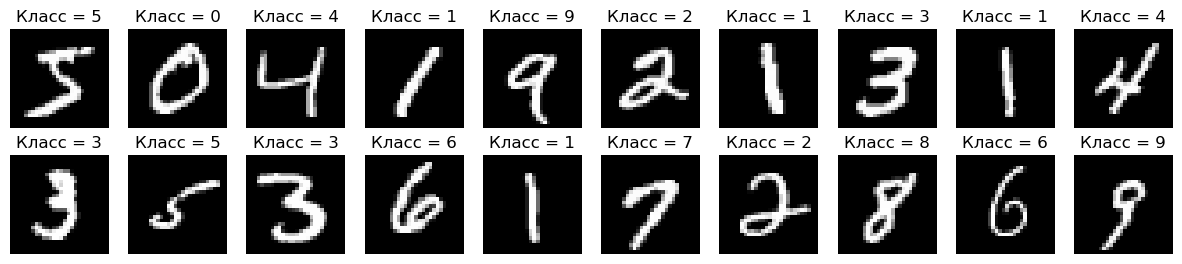

In [19]:
plt.figure(figsize=(15, 3))

for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.imshow(
        np.array(mnist["data"])[i].reshape(28, 28), cmap="gray"
    )  # выводим само изображение
    plt.title(
        f"Класс = {mnist['target'][i]}"
    )  # выводим истинные и предсказанные метки
    plt.axis("off")
plt.show()

Размер каждой картинки **28х28**, т.е. на каждый объект **784** признака, что довольно много. Работа с большим количеством признаков может оказаться сложной задачей, имеющей свои особенности, о которых вы узнаете в дальнейшем.

Так что сегодня мы ограничимся урезанной версией этого датасета, размер изображений которой составляет **8х8**.



In [20]:
digits = datasets.load_digits()

Данные изображений хранятся в переменной `images`, а соответствующие им метки классов — в переменной `target`.

* Каждый объект в наборе данных представлен в виде **черно-белого** (в градациях серого) изображения размером **8x8 пикселей**.
Каждый пиксель имеет значение в диапазоне от **0 до 16**, где:

  - **0** соответствует полностью черному цвету (это фон),
  - **16** — полностью белому (это сама цифра).

  Таким образом, чем выше значение пикселя, тем светлее он выглядит, приближаясь к белому цвету.

* Каждое изображение связано с **меткой класса**, представляющей собой одну из цифр от **0 до 9**. Эта метка указывает, какую именно цифру содержит данное изображение.

Визуализируем данные:

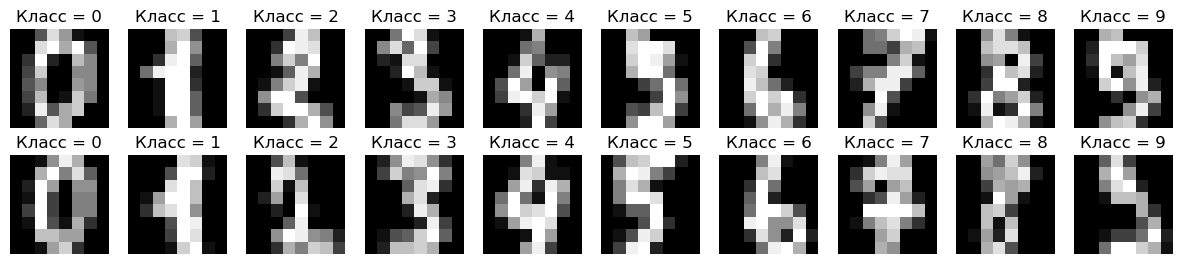

In [21]:
plt.figure(figsize=(15, 3))

for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.imshow(digits["images"][i], cmap="gray")  # выводим само изображение
    plt.title(
        f"Класс = {digits['target'][i]}"
    )  # выводим истинные и предсказанные метки
    plt.axis("off")
plt.show()

Наши данные представлены в виде матриц, а модели машинного обучения, в частности kNN, работают с векторами. Следовательно нам придется преобразовать все матрицы в вектора, т.е. просто растянуть их.

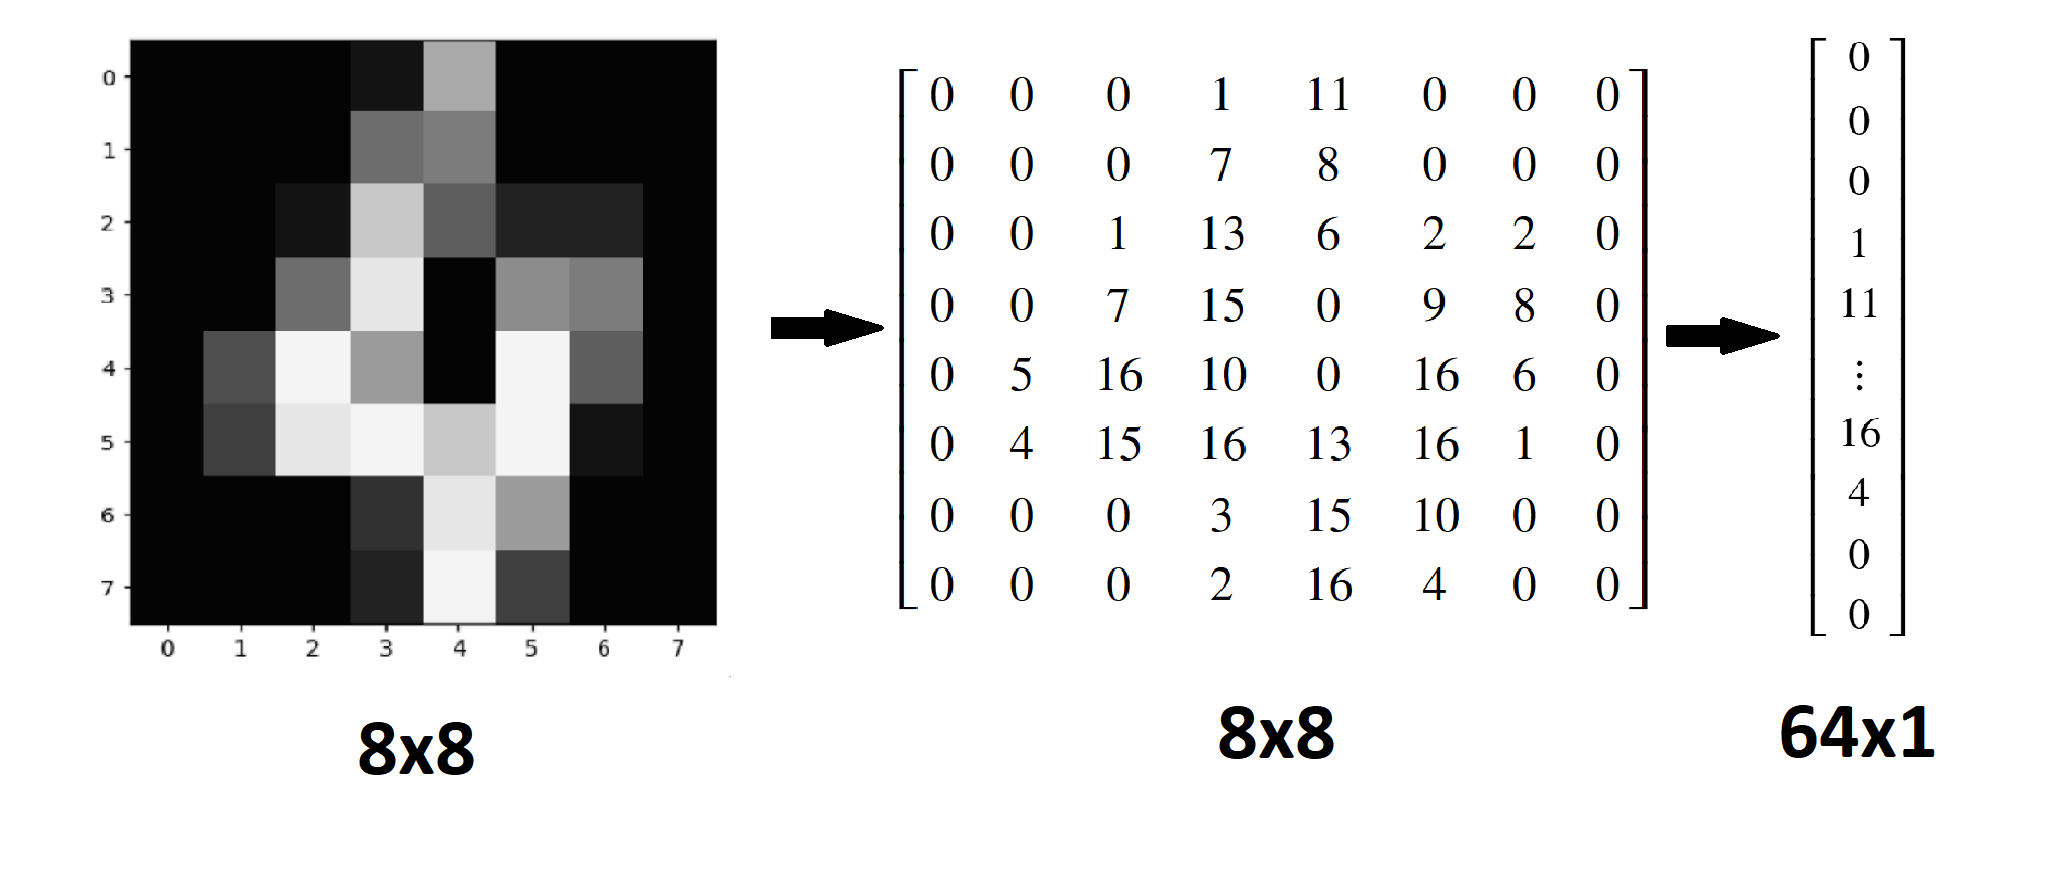

Разделим данные и переведем их в вектор.

In [22]:
n_samples = len(digits["images"])
X, y = digits["images"].reshape(n_samples, -1), digits["target"]

X.shape, y.shape

((1797, 64), (1797,))

Как мы видим, каждая строка имеет 64 признака, что соответствует общему числу пикселей на картинке 8x8, т.е. матрица изображения растянулась в вектор.

Далее нам необходимо датасет разделить на 2 набора данных: тренировочный и тестовый. Тренировочный набор нам нужен непосредственно для обучения модели, тестовый &mdash; для финальной оценки качества модели.

Для этого есть готовая функция [train_test_split](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.train_test_split.html) из модуля `sklearn.model_selection`.

`train_test_split(arrays, test_size=None, train_size=None, random_state=None)`
- `arrays`: массивы данных для разделения (например, признаки X и целевая переменная y).
- `test_size`: размер тестовой выборки. Может быть числом(количество образцов) или долей от общего числа образцов.
- `train_size`: размер обучающей выборки. Может быть числом (количество образцов) или долей от общего числа образцов.
- `random_state`: устанавливает начальное значение для генератора случайных чисел (повторяемость разделения данных).

*Примечание:*  Если параметры в `test_size`,`train_size` передать `None`, то размер тестовой выборки составит 25%.

> &#x2757; **Важно:** При обучении модель ничего не должна знать о тестовой выборке.

Разделим данные на тренировочную выборку и тестовую.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, random_state=random_state
)

### 2. kNN классификация

Обучим нашу первую модель &mdash; kNN-классификатор. Готовая [реализация](https://scikit-learn.org/1.5/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) этой модели уже есть в sklearn-е модуле `sklearn.neighbors`.

Создадим экземпляр классификатора:

- `n_neighbors`: количество соседей для учитывания при классификации.
- `weights`: веса, присваиваемые соседям (`uniform` &mdash; все веса одинаковы, `distance` &mdash; вес зависит от расстояния).
- `algorithm`: алгоритм для поиска ближайших соседей (`auto`, `ball_tree`, `kd_tree` `brute`).
- `p`: параметр метрики расстояния (1 &mdash; манхэттенское расстояние, 2 &mdash; евклидово расстояние и т.д.).

Выберем число соседей `n_neighbors = 5`, остальные параметры оставим по умолчанию.

&#x2753; **Вопрос** &#x2753;

> Как изменится точность модели, если использовать слишком большое значение $k$ (параметр `n_neighbors`)?

<details>
  <summary> Кликни для показа ответа </summary>
  
> Когда параметр $k$ увеличивается, модель начинает учитывать больше ближайших соседей для принятия решения о классе объекта. При большом значении $k$ модель становится менее чувствительной к выбросам, так как решение принимается не только по ближайшим точкам, но и по большему числу соседей. Однако увеличение $k$ также может привести к потере важной локальной информации. Если данные имеют сложную структуру с множеством мелких кластеров, то использование большого числа соседей может сгладить эти особенности и ухудшить точность классификации в таких областях.

</details><br/>

In [24]:
model = KNeighborsClassifier(n_neighbors=5, algorithm="brute")

Для обучения *любой* модели в sklearn-е используется метод класса  `fit(X_train, y_train)`.

- `X_train`: массив признаков обучающей выборки.
- `y_train`: массив меток классов обучающей выборки.

In [25]:
model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='brute')

&#x2753; **Вопрос** &#x2753;

> Что метод `fit` сделал в данном случае? Что есть обучение kNN?

<details>
  <summary> Кликни для показа ответа </summary>
  
> В контексте kNN в случае `algorithm="brute"` "обучением" называется процесс запоминания всех данных, предоставленных для обучения. То есть модель просто сохраняет все точки данных вместе с их метками классов. Никакие дополнительные вычисления или оптимизации параметров не производятся.

 >С одной стороны это делает kNN простым и адаптивным, так как, если данные обновляются, новая версия модели создается мгновенно, без необходимости повторного обучения.  Однако, с другой стороны, это замедляет работу модели и снижает его эффективность на сложных задачах, где требуется выявление сложных взаимосвязей в данных.
</details><br/>


Теперь когда мы обучили модель, мы можем использовать ее для получения предсказаний. Для этого аналогично обучению существует метод `model.predict(X_test) `

- `X_test`: массив признаков тестовой выборки.

In [26]:
y_pred = model.predict(X_test)

&#x2753; **Вопрос** &#x2753;

> Что метод `predict` сделал в данном случае? Что есть предсказание kNN?

<details>
  <summary> Кликни для показа ответа </summary>
  
> Для каждого элемента из тестовой выборки выбираются $k$ ближайших соседей из тренировочной выборки по измеренному расстоянию. Новый объект классифицируется путем голосования среди выбранных $k$.
Класс, который встречается чаще всего среди этих соседей, присваивается новому объекту.
</details><br/>

При работе с большими наборами данных поиск ближайших соседей может занять значительное время. Для ускорения можно использовать специализированные структуры данных:
- KD-дерево (`algorithm="kd_tree"`): позволяет быстро находить ближайшие соседи за логарифмическое время,
- BallTree (`algorithm="ball_tree"`): еще одна структура данных, которая ускоряет поиск.  




&#x2753; **Вопрос** &#x2753;

> Почему метод kNN может работать медленно на больших данных?

<details>
  <summary> Кликни для показа ответа </summary>
  
> Основная операция метода kNN заключается в вычислении расстояния между каждым новым объектом и всеми объектами обучающей выборки. Для каждой новой точки нужно найти её $k$ ближайших соседей среди всех объектов в наборе данных. Если количество объектов велико, это требует значительных вычислительных ресурсов. Вычислительная сложность поиска ближайшего соседа для одного нового объекта составляет
$O(n\cdot d)$, где $n$ – число объектов в обучающем множестве, а $d$ – размерность пространства признаков.  

> Простой подход к поиску ближайших соседей (brute force search) имеет высокую временную сложность $O(n)$.  
</details><br/>

Посмотрим на результат предсказания.

In [27]:
y_pred.shape, y_pred[:15]

((540,), array([6, 9, 3, 7, 2, 1, 5, 2, 5, 2, 1, 9, 4, 0, 4]))

У нас есть истинные метки классов `y_test` и предсказанные моделью `y_pred`. Для оценки качества модели осталось только их сравнить.




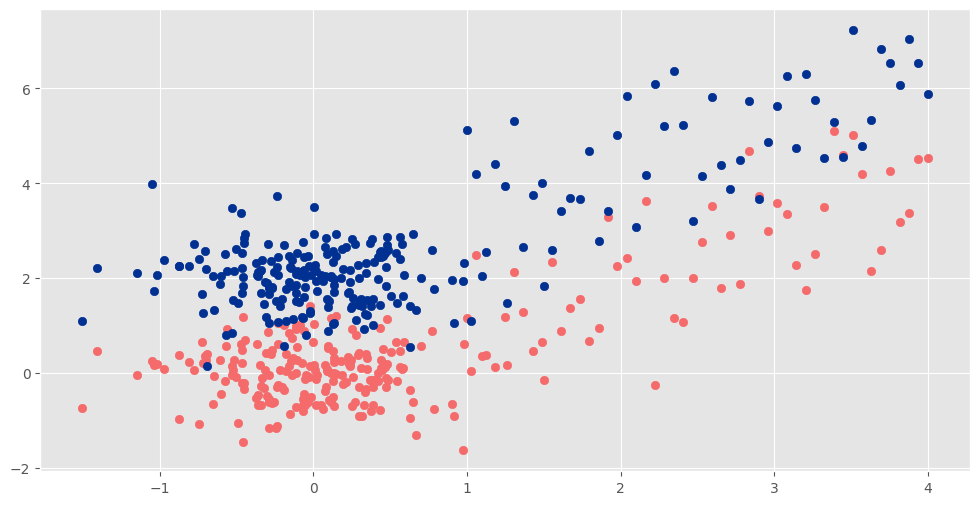

&#x2753; **Вопрос** &#x2753;

> Если данные распределены неравномерно, например, одна часть плотно сгруппирована, а другая разрежена, как это может повлиять на результаты kNN?

<details>
  <summary> Кликни для показа ответа </summary>
  
>  Как мы помним, наш метод строит предсказания, основываясь на предположении о схожести соседних объектов в метрическом пространстве.

> В плотных областях данных в небольшой окрестности каждой точки расположено довольно много объектов, соответственно, принцип схожести будет соблюдаться в том числе и для больших $k$. Это позволит модели быть более устойчивой в этой области данных, менее зависимой от шумов в данных.

> Однако, в разреженных областях даже в большой окрестности будет расположено мало объектов, соответственно, для соблюдения принципа схожести необходимо брать небольшие значения $k$, иначе модель может выдавать сильно смещенные предсказания.

> В итоге получаем, что не существует значения $k$, которое было бы оптимальным для всего пространства данных.
</details><br/>

### 3. Визуализация результатов

Давайте посмотрим на то, как предсказанные значения согласуются с реальными.

In [28]:
def get_random_image(X, predicted_labels, real_labels):
    """Выбирает случайный элемент из выборки и возвращает матрицу изображения,
    метки класса, предсказанные моделью, и реальные.

    Принимает:
    * X - Матрица изображений.
    * predicted_labels - Массив предсказанных меток классов.
    * real_labels -  Массив реальных меток классов.
    Возвращает:
    * random_digit_image - Случайное изображение, преобразованное в матрицу размером 8x8.
    * random_digit_label - Предсказанная метка класса для выбранного изображения.
    * real_label - Реальная метка класса для выбранного изображения.
    """

    random_digit_number = np.random.randint(
        1, len(y_test)
    )  # выбираем случайный индекс из тестовой выборки
    random_digit_image = X[random_digit_number].reshape(
        int(np.sqrt(X.shape[1])), int(np.sqrt(X.shape[1]))
    )  # преобразуем вектор признаков обратно в матрицу
    random_digit_label = predicted_labels[
        random_digit_number
    ]  # предсказанная метка
    real_label = real_labels[random_digit_number]  # реальная метка

    return random_digit_image, random_digit_label, real_label

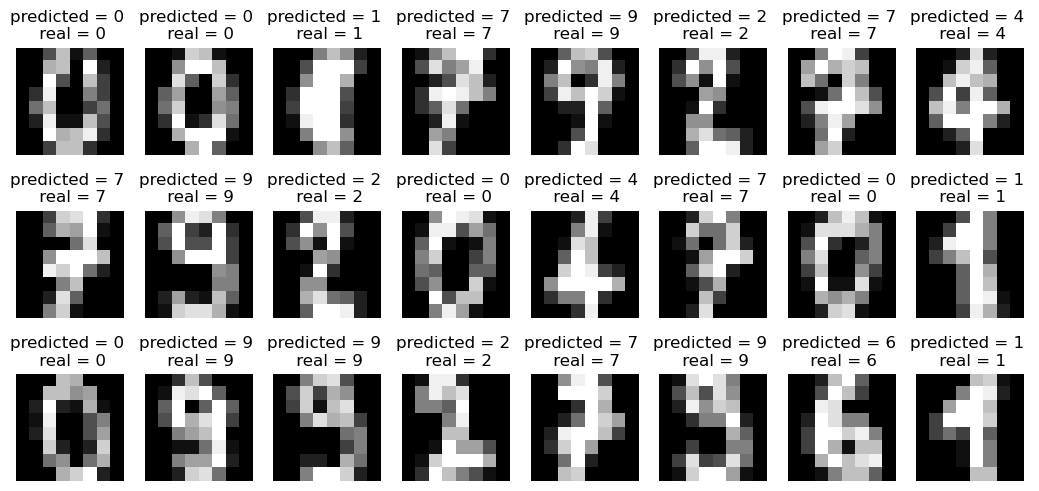

In [29]:
plt.figure(figsize=(13, 6))

for i in range(24):
    plt.subplot(3, 8, i + 1)
    image, predicted_label, real_label = get_random_image(
        X_test, y_pred, y_test
    )
    plt.imshow(image, cmap="gray")  # выводим само изображение
    plt.title(
        f"predicted = {predicted_label} \n real = {real_label}"
    )  # выводим истинные и предсказанные метки
    plt.axis("off")
plt.show()

Как вы могли заметить, на тестовой выборке у нас 540 изображений, и сравнивать все вручную будет довольно проблематично. Для оценки качества моделей вводится такое понятие, как *метрика*.

Не стоит путать с метрикой в метрическом пространстве, которая используется для поиска ближайших соседей. *Метрика качества* же помогает оценить, насколько правильно эти соседи определяют класс нового объекта.







### 4. Метрика и качество модели

Первая идея — это просто посчитать долю правильно угаданных объектов. Такой критерий качества называется **accuracy**.
Пусть $Y_1, ..., Y_n$ &mdash; истинные значения, а  $\widehat{Y}_1,...,\widehat{Y}_n$
  — предсказания. Тогда

$$Accuracy = \frac{1}{n} \sum_{i=1}^{n} I\{Y_i = \widehat{Y}_i\}$$

Как вы уже могли догадаться, в sklearn-е есть готовая [реализация](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.accuracy_score.html) этой метрики в модуле `sklearn.metrics` функция `accuracy_score`.

`accuracy_score(y_true, y_pred)`

- `y_true`: массив меток класса на тестовом наборе данных
- `y_pred`: массив меток класса предсказанный нашей моделью

Оценим качество нашей модели по метрике accuracy.


In [30]:
score = accuracy_score(y_test, y_pred)
print(f"метрика accuracy = {score*100:.2f}%")

метрика accuracy = 99.26%


Число 99% должно нас очень сильно радовать, но все же, перед тем как говорить об эффективности модели, стоит сравнить с каким-то бейзлайном. К примеру, возьмем самый частый класс и присвоим это значение всем элементам тестовой выборки

In [31]:
vals, counts = np.unique(y_train, return_counts=True)
naive_class = vals[np.argmax(counts)]
print(f"Самый популярный класс - {naive_class}")

Самый популярный класс - 1


In [32]:
y_pred = np.full(len(y_test), naive_class)
score = accuracy_score(y_test, y_pred)
print(f"метрика accuracy = {score*100:.2f}%")

метрика accuracy = 9.26%


&#x2753; **Вопрос** &#x2753;

> Почему у самого популярного класса точность меньше 10%? Кажется, должно быть не меньше.

<details>
  <summary> Кликни для показа ответа </summary>
  
> Тут стоит отметить, что самый популярный класс был определен на тренировочной выборке. Для тестовой же &mdash; самый популярный класс может оказаться совершенно другим, т.к. разбиение случайное.
</details><br/>

Теперь мы можем утверждать, что модель k-ближайших соседей (kNN) продемонстрировала высокую точность в 99%, значительно превосходя базовый уровень в 9%. Это подтверждает высокую эффективность модели в данном контексте. Однако стоит рассмотреть, как другие современные модели справляются с аналогичными задачами.


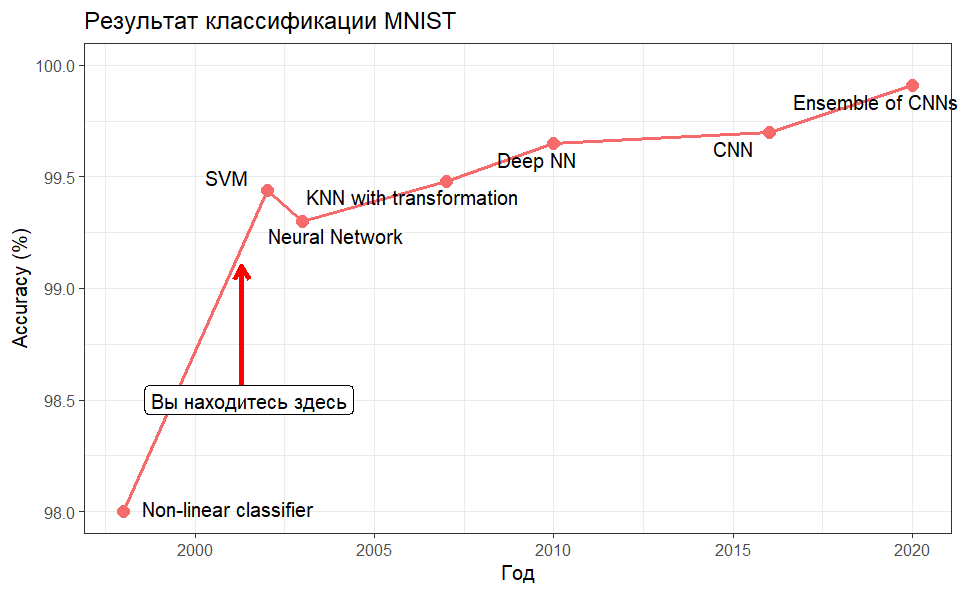

Подробнее об этом можно почитать [здесь](https://yann.lecun.com/exdb/mnist/).

История классификации датасета MNIST отражает эволюцию методов машинного обучения и искусственного интеллекта. От простых линейных классификаторов до глубоких сверточных нейронных сетей — прогресс был значительным. Сегодня MNIST служит скорее отправной точкой для изучения новых идей и технологий, нежели сложной задачей, требующей решения. Тем не менее, современные модели, такие как сверточные нейронные сети (CNN), рекуррентные нейронные сети (RNN) и трансформеры, продолжают совершенствоваться, предлагая все более точные и эффективные решения для разнообразных задач, выходящих далеко за рамки простого распознавания рукописных цифр. И наша цель познакомить вас со всем многообразием этих моделей от самых простых до самых эффективных.

